In [1]:
from os import path as osp
import numpy as np
import tensorflow as tf
import sonnet as snt

from tensorflow.contrib.distributions import Bernoulli

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
% matplotlib inline

from neurocity import minimize_clipped
from neurocity.tools.params import num_trainable_params

from tf_tools.eval import make_expr_logger

from data import load_data, tensors_from_data
from model import AIRCell
from ops import Loss

In [2]:
learning_rate = 1e-4
batch_size = 64
img_size = 50, 50
crop_size = 20, 20
n_latent = 50
n_hidden = 256
n_steps = 3

results_dir = '../results'
run_name = 'prior'

logdir = osp.join(results_dir, run_name)
checkpoint_name = osp.join(logdir, 'model.ckpt')
axes = {'imgs': 0, 'labels': 0, 'nums': 1}

In [3]:
prior_weight = .3

num_steps_prior = 0.
latent_code_prior = 0.

use_reinforce = True

init_explore_eps = .05

In [4]:
test_data = load_data('mnist_test.pickle')
train_data = load_data('mnist_train.pickle')

In [5]:
tf.reset_default_graph()
train_tensors = tensors_from_data(train_data, batch_size, axes, shuffle=True)
test_tensors = tensors_from_data(test_data, batch_size, axes, shuffle=False)
x, test_x = train_tensors['imgs'], test_tensors['imgs']
y, test_y = train_tensors['nums'], test_tensors['nums']

explore_eps = tf.get_variable('explore_eps', initializer=init_explore_eps, trainable=False)

transition = snt.LSTM(n_hidden)
air = AIRCell(img_size, crop_size, n_latent, transition, max_crop_size=1.0,
              canvas_init=None,
              sample_presence=True,
              presence_bias=1.,
              explore_eps=explore_eps,
              debug=True)

initial_state = air.initial_state(x)

dummy_sequence = tf.zeros((n_steps, batch_size, 1), name='dummy_sequence')
outputs, state = tf.nn.dynamic_rnn(air, dummy_sequence, initial_state=initial_state, time_major=True)
canvas, cropped, what, where, presence_logit, presence = outputs
presence_prob = tf.nn.sigmoid(presence_logit)

with tf.variable_scope('notebook'):
    cropped = tf.reshape(presence * tf.nn.sigmoid(cropped), (n_steps, batch_size,) + tuple(crop_size))
    canvas = tf.reshape(canvas, (n_steps, batch_size,) + tuple(img_size))
#     prob_canvas = tf.nn.sigmoid(canvas)
    prob_canvas = canvas
    final_canvas = canvas[-1]
    
    
with tf.variable_scope('baseline'):
    constant_baseline = snt.TrainableVariable([], initializers={'w': tf.zeros_initializer()}, name='constant_baseline')
    parts = [tf.reshape(tf.transpose(i, (1, 0, 2)), (batch_size, -1)) for i in (what, where, presence_prob)]
    img_flat = tf.reshape(x, (batch_size, -1))
    baseline_inpts = [img_flat] + parts
    baseline_inpts = tf.concat(baseline_inpts, -1)
    
    lin1 = snt.Linear(100)
    lin2 = snt.Linear(1)
    seq = snt.Sequential([lin1, tf.nn.elu, lin2])
    baseline = seq(baseline_inpts) + constant_baseline()
    
    baseline_mean = tf.reduce_mean(baseline)

In [6]:
print num_trainable_params()

1257183.0


In [7]:
# print latent_code_prior_loss_per_sample.get_shape()
# print latent_code_prior_loss.get_shape()
# print prior_loss._per_sample.get_shape()
# print prior_loss.value.get_shape()

In [8]:
###    Loss #################################################################################
loss = Loss()
prior_loss = Loss()
train_step = []
lr_tensor = tf.Variable(learning_rate, name='learning_rate', trainable=False)

###    Reconstruction Loss ##################################################################
# rec_loss_per_sample = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=final_canvas)
rec_loss_per_sample = (x - final_canvas) ** 2

rec_loss_per_sample = tf.reduce_sum(rec_loss_per_sample, axis=(1, 2))
rec_loss = tf.reduce_mean(rec_loss_per_sample)
tf.summary.scalar('rec_loss', rec_loss)

loss.add(rec_loss, rec_loss_per_sample)
# # ###    Prior Loss ###########################################################################

num_step_per_sample = tf.to_float(tf.squeeze(tf.reduce_sum(presence, 0)))
num_step = tf.reduce_mean(num_step_per_sample)
if prior_weight > 0.:
    
    if num_steps_prior is not None:    
        num_steps_prior_loss_per_sample = tf.squeeze((tf.reduce_sum(presence, 0) - num_steps_prior) ** 2)
        num_steps_prior_loss = tf.reduce_mean(num_steps_prior_loss_per_sample)
        
        tf.summary.scalar('num_steps_prior_loss', num_steps_prior_loss)
        prior_loss.add(num_steps_prior_loss, num_steps_prior_loss_per_sample)

    if latent_code_prior is not None:
        div = tf.where(tf.greater(num_step_per_sample, 0.), num_step_per_sample, tf.ones_like(num_step_per_sample))
        latent_code_prior_loss_per_sample = tf.reduce_sum((what - latent_code_prior) ** 2, -1) * tf.squeeze(presence)
        latent_code_prior_loss_per_sample = tf.reduce_sum(latent_code_prior_loss_per_sample, 0) / div
        latent_code_prior_loss = tf.reduce_mean(latent_code_prior_loss_per_sample)
        
        tf.summary.scalar('latent_code_prior_loss', latent_code_prior_loss)
        prior_loss.add(latent_code_prior_loss, latent_code_prior_loss_per_sample)

    tf.summary.scalar('prior_loss', prior_loss.value)
    loss.add(prior_loss, weight=prior_weight)

# ###   REINFORCE ############################################################################

opt_loss = loss.value
if use_reinforce:
    clipped_presence_prob = tf.clip_by_value(presence_prob, 1e-7, 1. - 1e-7)
    log_prob = Bernoulli(probs=clipped_presence_prob).log_prob(presence)
    log_prob = tf.squeeze(tf.reduce_mean(log_prob, 0))
#     log_prob *= -1 # cause we're maximising
    
#     # instead of maximising probability we'll minimise cross-entropy, where labels are the taken actions
#     log_prob = tf.nn.sigmoid_cross_entropy_with_logits(labels=presence, logits=presence_logit)

    importance_weight = loss._per_sample
    importance_weight -= baseline

    reinforce_loss_per_sample = tf.stop_gradient(importance_weight) * log_prob
    reinforce_loss = tf.reduce_mean(reinforce_loss_per_sample)
    tf.summary.scalar('reinforce_loss', reinforce_loss)

    opt_loss += reinforce_loss
    
    ### Baseline Optimisation ##################################################################################
    baseline_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='baseline')
    baseline_target = tf.stop_gradient(loss.per_sample)
    baseline_loss_per_sample = (baseline_target - baseline) ** 2
    baseline_loss = tf.reduce_mean(baseline_loss_per_sample)
    tf.summary.scalar('baseline_loss', baseline_loss)

    baseline_opt = tf.train.RMSPropOptimizer(10 * lr_tensor, momentum=.9, centered=True)
    baseline_train_step = baseline_opt.minimize(baseline_loss, var_list=baseline_vars)
    train_step.append(baseline_train_step)

    
### Optimizer #################################################################################

opt = tf.train.RMSPropOptimizer(lr_tensor, momentum=.9, centered=True)
# true_train_step = opt.minimize(opt_loss)
true_train_step = minimize_clipped(opt, opt_loss, clip_value=.3, normalize_by_num_params=True)
train_step.append(true_train_step)


###    Metrics #################################################################################
gt_num = tf.reduce_sum(y, 0)
num_step_accuracy = tf.reduce_mean(tf.to_float(tf.equal(gt_num, num_step_per_sample)))

In [9]:
print presence.get_shape()
print what.get_shape()

(3, 64, 1)
(3, 64, 50)


In [10]:
vs = tf.trainable_variables()
gs = tf.gradients(opt_loss, vs)

for v, g in zip(vs, gs):
    if g is None:
        print 'Skipping', v.name
    else:
        assert v.get_shape() == g.get_shape(), v.name

named_grads = {v.name: g for v, g in zip(vs, gs) if g is not None}

Skipping baseline/linear/w:0
Skipping baseline/linear/b:0
Skipping baseline/linear_1/w:0
Skipping baseline/linear_1/b:0
Skipping baseline/constant_baseline/w:0


In [11]:
def grad_variance(n=10, sort_by_var=True):
    gs = {k: [] for k in named_grads}
    for i in xrange(n):
        values = sess.run(named_grads)
        for k, v in values.iteritems():
            gs[k].append(v)

    for k, v in gs.iteritems():
        v = np.stack(v, 0).reshape((n, -1))
        gs[k] = np.var(v, 0).mean()
        
    sort_idx = 1 if sort_by_var else 0
    gs = sorted(gs.items(), key=lambda x: x[sort_idx], reverse=True)
    return gs

def print_grad_variance():
    grad_vars = grad_variance(10)
    print
    for g in grad_vars:
        if g[1] > 1e-2:
            print g
    print

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
all_summaries = tf.summary.merge_all()

In [13]:
summary_writer = tf.summary.FileWriter(logdir)
saver = tf.train.Saver()

In [14]:
imgs = train_data['imgs']
presence_gt = train_data['nums']
train_itr = -1

In [15]:
def make_fig(checkpoint_dir=None, global_step=None):
    xx, pred_canvas, pred_crop, pres = sess.run([x, prob_canvas, cropped, presence])

    max_imgs = 10
    bs = min(max_imgs, batch_size)
    scale = 1.
    figsize = scale * np.asarray((bs, 2 * n_steps + 1))
    fig, axes = plt.subplots(2 * n_steps + 1, bs, figsize=figsize)

    for i, ax in enumerate(axes[0]):
        ax.imshow(xx[i], cmap='gray', vmin=0, vmax=1)

    for i, ax_row in enumerate(axes[1:1+n_steps]):
        for j, ax in enumerate(ax_row):
            ax.imshow(pred_canvas[i, j], cmap='gray', vmin=0, vmax=1)

    for i, ax_row in enumerate(axes[1+n_steps:]):
        for j, ax in enumerate(ax_row):
            ax.imshow(pred_crop[i, j], cmap='gray')#, vmin=0, vmax=1)
            ax.set_title('{:.02f}'.format(pres[i, j, 0]), fontsize=4*scale)

    for ax in axes.flatten():
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    if checkpoint_dir is not None:
        fig_name = osp.join(checkpoint_dir, 'progress_fig_{}.png'.format(global_step))
        fig.savefig(fig_name, dpi=300)
        plt.close('all')
    
exprs = {
    'loss': loss.value,
    'rec_loss': rec_loss,
    'num_step_acc': num_step_accuracy,
    'num_step': num_step
}

if prior_weight > 0:
    exprs['prior_loss'] = prior_loss.value
    if num_steps_prior is not None:    
        exprs['num_steps_prior_loss'] = num_steps_prior_loss

    if latent_code_prior is not None:
        exprs['latent_code_prior_loss'] = latent_code_prior_loss

if use_reinforce:
    exprs['baseline_loss'] = baseline_loss
    exprs['reinforce_loss'] = reinforce_loss
    exprs['imp_weight'] = tf.reduce_mean(importance_weight)
    
train_log = make_expr_logger(sess, summary_writer, train_data['imgs'].shape[0] / batch_size, exprs, name='train')
test_log = make_expr_logger(sess, summary_writer, test_data['imgs'].shape[0] / batch_size, exprs, name='test', data_dict={x: test_x, y: test_y})

def log(train_itr):
    train_log(train_itr)
    test_log(train_itr)

In [21]:
for train_itr in xrange(train_itr+1, int(1e7)):
        
    sess.run(train_step)
    if train_itr % 1000 == 0:
        summaries = sess.run(all_summaries)
        summary_writer.add_summary(summaries, train_itr)
        
    if train_itr % 1000 == 0:
        log(train_itr)
        
        
        
        
        
    if train_itr % 1000 == 0:
#         saver.save(sess, checkpoint_name, global_step=train_itr)
        make_fig(logdir, train_itr)    
    
    if train_itr % 1000 == 0:
        print 'baseline value = {}'.format(sess.run(baseline_mean))
        print_grad_variance()

Step 2000, Data train prior_loss = 8.8492, loss = 14.8627, latent_code_prior_loss = 0.3942, imp_weight = 0.0938, num_steps_prior_loss = 8.4551, baseline_loss = 189.4687, reinforce_loss = -71.3717, rec_loss = 12.2079, num_step = 2.8509, num_step_acc = 0.0246, eval time = 11.89s
Step 2000, Data test prior_loss = 8.7312, loss = 13.7726, latent_code_prior_loss = 0.3749, imp_weight = -0.9699, num_steps_prior_loss = 8.3562, baseline_loss = 170.1985, reinforce_loss = -58.3763, rec_loss = 11.1532, num_step = 2.8229, num_step_acc = 0.0290, eval time = 0.2036s
baseline value = 14.8170452118

(u'AIRCell/Encoder_1/linear_1/b:0', 0.045179535)
(u'AIRCell/Decoder/linear/b:0', 0.022202689)
(u'AIRCell/Encoder/linear/b:0', 0.019158728)
(u'where_init:0', 0.011426727)

Step 3000, Data train prior_loss = 8.7842, loss = 14.3722, latent_code_prior_loss = 0.3277, imp_weight = 0.4741, num_steps_prior_loss = 8.4565, baseline_loss = 186.9967, reinforce_loss = -72.1213, rec_loss = 11.7369, num_step = 2.8511, num_

KeyboardInterrupt: 

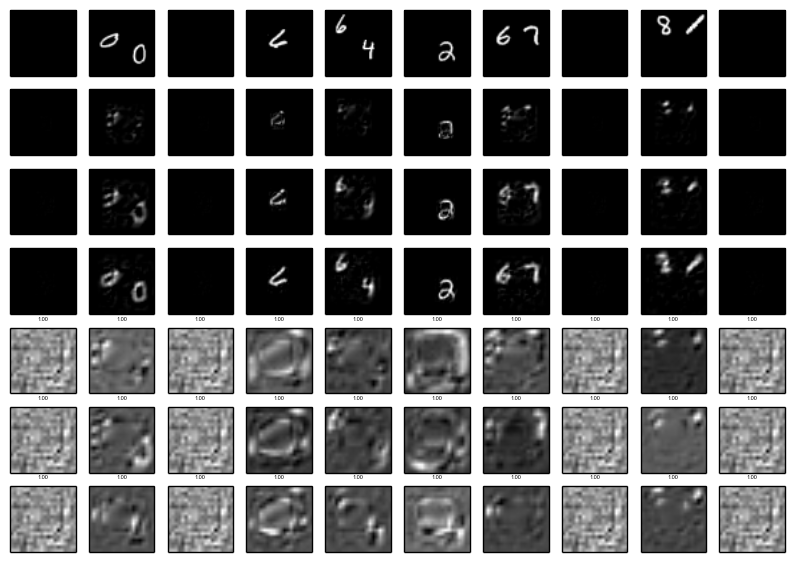

In [22]:
make_fig()